In [569]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Reverse Logistics Profit Model
06/26/2025

## Introduction
Hello everyone! I hope the Summer is treating you all well. So, a couple weeks ago a friend reached out to me about a reverse logistics startup idea they were thinking of pursuing. He contacted me because he was aware of my background in data science and wanted to pick my brain on some data science pieces related to their idea. I really liked his idea largely because of its focus on sustainability and the second hand clothing market, but also because I genuinely believe it can work. As a result, I've become fairly invested in exploring how I can leverage the data science concepts and skills in my toolbelt to minimize the risk of his business model while maximizing its overall success. The following notebooks entail my process in this effort leveraging Poshmark data I was able to scrape from the Internet.

## Task
There are two questions that this analysis will prioritize answering: What price should be charged for the services and for which clothing items should this service be offered? In regard to the first question, there are two main costs that the user would incur: an upfront fee to opt-in to the service and a percentage fee if we are able to successfully resell their item. As a result, we will need to determine what price to set for the first and percentage to charge for the second such that we minimize risk in our profit model. As for the second task, we are looking to target clothing that have a high liklihood of being resold such that we reduce overhead costs and improve the value prop of our service.

To answer the latter question I will employ a handful of feature selection and machine learning algorithms on our data to determine which characteristics are good for assessing whether an item will resell or not. As for the former, we will use a non-linear programming model to determine what price points optimize the profit model. 

## Data

Accomplishing these tasks require a large set of second-hand clothing stock and sales data that provide information on characteristics of the clothing (i.e. price, brand, category, style, listing date, etc.) and whether the clothing has sold or not. To do this, I built a websraper tool, `poshmark_scraper.py`, using Selenium and Beautiful Soup to collect a random sample of 5000+ listings from Poshmark's website and scrape the following data from each listing: Listing Price, Shipping Cost, Style Tags, Color, Brand, Condition, Size, Department, Category, Sub-category, Bundle Offered, Price Drop, and whether it has sold. 

The webscraper only collected listings from the Mens, Womens, and Kids departments. Furthermore, the number of listings collected from each department were proportionate to the number of items listed in each department on Poshmarks website.

## Pre-processing





In [570]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler

Below I've defined two small utility functions that will help keep my work a little more conscise.

In [571]:
def parse_list_literal(s: str) -> list[str]:
    """Safely turn a stringified Python list into a lowercase list of strings."""
    if not isinstance(s, str): return []
    try:
        items = ast.literal_eval(s)
    except Exception:
        return []
    return [str(item).strip().lower() for item in items if isinstance(item, str)]

def binarize_multilabel(col: pd.Series, prefix: str) -> pd.DataFrame:
    """Multi-hot encode a Series of lists via sklearn’s MultiLabelBinarizer."""
    mlb = MultiLabelBinarizer()
    arr = mlb.fit_transform(col)
    cols = [f"{prefix}_{c}" for c in mlb.classes_]
    return pd.DataFrame(arr, columns=cols, index=col.index)


In [572]:
df = pd.read_csv('../data/raw/poshmark_sample.csv')
df.head()


,url,listing_price,price_drop,discounted_shipping,style_tags,color,brand,new_with_tags,size,sub_category,category,bundle,listing_date,sold
0,https://poshmark.com/listing/Sue-Wong-Womens-S...,45,NaN,$8.27,"['Fairy', 'Retro', 'Hipster']",[],Sue Wong,False,['S'],Blouses,"['Women', 'Tops']",True,2025-06-19,False
1,https://poshmark.com/listing/Pilcro-Anthropolo...,48,NaN,$8.27,"['Bootcut', 'Flare']",['Blue'],Pilcro,False,['31'],Flare & Wide Leg,"['Women', 'Jeans']",True,2025-05-30,False
2,https://poshmark.com/listing/One-Teaspoon-Cott...,65,128,$8.27,"['Streetwear', 'Fashion', 'Revolve']",['Black'],One Teaspoon,True,['25'],Mini,"['Women', 'Skirts']",False,2024-08-04,False
3,https://poshmark.com/listing/Lush-LeahShiftDre...,8,30,$8.27,[],['Purple'],Lush,True,['XS'],Mini,"['Women', 'Dresses']",True,2025-05-23,False
4,https://poshmark.com/listing/Fortune-Ivy-Open-...,30,NaN,$8.27,"['Fall', 'Cozy', 'Stitchfix']",['Gray'],Fortune + Ivy,False,['M'],Cardigans,"['Women', 'Sweaters']",False,2025-06-14,False


First, I conducted a quick inspection of my dataset to determine the type, cardinality, and number of null values for each column.

In [573]:
df.info()
df.describe(include='all').T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5021 entries, 0 to 5020
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   url                  5021 non-null   object
 1   listing_price        5015 non-null   object
 2   price_drop           2940 non-null   object
 3   discounted_shipping  5015 non-null   object
 4   style_tags           5021 non-null   object
 5   color                5021 non-null   object
 6   brand                4651 non-null   object
 7   new_with_tags        5021 non-null   bool  
 8   size                 5021 non-null   object
 9   sub_category         4158 non-null   object
 10  category             5015 non-null   object
 11  bundle               5021 non-null   bool  
 12  listing_date         5015 non-null   object
 13  sold                 5021 non-null   bool  
dtypes: bool(3), object(11)
memory usage: 446.3+ KB


,count,unique,top,freq
url,5021,5021,https://poshmark.com/listing/NIKE-Toddler-Blue...,1
listing_price,5015,235,20,307
price_drop,2940,347,50,85
discounted_shipping,5015,4,$8.27,4891
style_tags,5021,2263,[],2580
color,5021,208,['Black'],637
brand,4651,1894,Nike,143
new_with_tags,5021,2,False,3972
size,5021,514,['OS'],771
sub_category,4158,224,Blouses,240


### 1. Create Response Variable

Next, a create my response variable. Using the `listing_date` variable, I calculate how long an item has been listed from the data collection date. Then create a variable, `sellable`, that is 0 if the item has been listed for over 90 days and has not been sold, and 1 if that item has been sold within 90 days. Any records that don't fall into either of these categories are dropped.


In [574]:
df['listing_date'] = pd.to_datetime(df['listing_date'])
ref_date = pd.Timestamp(2025,6,25)
df['days_since_listing'] = (ref_date - df['listing_date']).dt.days

mask_sellable = (df['days_since_listing'] < 90) & (df['sold'])
mask_not      = (df['days_since_listing'] > 90) & (~df['sold'])

# assign sellable = 1 when mask_sellable, 0 when mask_not, else NaN (or some default)
df['sellable'] = np.where(
    mask_sellable, 1,
    np.where(mask_not, 0, np.nan)
)

# drop all the “other” rows (where sellable is NaN):
df = df[df['sellable'].notna()].copy()
df['sellable'] = df['sellable'].astype(int)


### 2. Clean Listing Price

Here, I removed any non-digits characters from the listing price column and casted all values to float.

In [575]:
df['listing_price'] = (
    pd.to_numeric(
        df['listing_price'].astype(str)
                        .str.replace(r'[^\d]', '', regex=True),
        errors='coerce'
    )
    .astype(float)
)


### 3. Compute Price Drop Fraction

The webscraper stores one of two values within the price drop column: the percentage decrease in the sales price of the listing or the original price of the listing. The former always contains a percent sign. To unify this data, I calculate the percentage change in price of the records containing the latter value using `listing_price`, then I strip all non-digit characters, and cast both values to type float. 

In [576]:
mask_pct = df['price_drop'].astype(str).str.contains('%', na=False)

# percent
pct = (
    df.loc[mask_pct, 'price_drop'].astype(str)
      .str.replace(',', '').str.rstrip('%').astype(float).div(100)
      .fillna(0)
)
# absolute
abs_vals = pd.to_numeric(
    df.loc[~mask_pct,'price_drop'].astype(str).str.replace(',', ''),
    errors='coerce'
)
abs_frac = ((abs_vals - df.loc[~mask_pct,'listing_price'])
            .div(abs_vals).fillna(0))

df['price_drop'] = 0.0
df.loc[mask_pct,'price_drop'] = pct
df.loc[~mask_pct,'price_drop'] = abs_frac


### 4. Split Category into Two Columns
Here I separate out the department from the category creating two columns. Then I drop categories we don't wish to consider.


In [577]:
def split_cat(s):
    try:
        a = ast.literal_eval(s)
        return pd.Series({'department':a[0],'categories':a[1]})
    except:
        return pd.Series({'department':None,'categories':None})

df = df.join(df['category'].apply(split_cat))


In [578]:
drop_set = {'Makeup','Skincare','Bath & Body','Toys','Other'}
df = df[~df['categories'].isin(drop_set)].copy()


### 5. Rare Level Grouping

The `brand` and `style_tags` columns have a high cardinalities. To reduce later complexity during feature selection, I decided to group the bottom tail of infrequent levels into an other category. I first determined the value count and cumulative percentage of each value. Then, I set my cut off threshold to capture values that occur at least twice. 

In [579]:
# Compute counts and cumulative percentages 
brand_counts = df['brand'].value_counts()
brand_cum_pct = brand_counts.cumsum() / brand_counts.sum()
brand_df = pd.DataFrame({
    'count': brand_counts,
    'cumulative_pct': brand_cum_pct.round(3)
})

cutoff = brand_df[brand_df['cumulative_pct'] >= 0.663].index[0]
top_brands = brand_df.loc[:cutoff].index.tolist()

df['brand'] = df['brand'].where(df['brand'].isin(top_brands), 'other')

In [580]:
df['style_tags_list'] = df['style_tags'].apply(parse_list_literal)

# Flatten all tags into a single list
all_tags = [tag for sublist in df['style_tags_list'] for tag in sublist]

# Compute counts and cumulative percentages
tag_counts = pd.Series(all_tags).value_counts()
tag_cum_pct = tag_counts.cumsum() / tag_counts.sum()
tag_df = pd.DataFrame({
    'count': tag_counts,
    'cumulative_pct': tag_cum_pct.round(3)
})

cutoff = tag_df[tag_df['cumulative_pct'] >= 0.741].index[0]
top_tags = tag_df.loc[:cutoff].index.tolist()

df['style_tags'] = df['style_tags'].where(df['style_tags'].isin(top_tags), 'other')

### 6. Outlier Detection & Treatment

Examining the `price_drop` category there appear to be extreme price drop values that may be caused by malformed data.

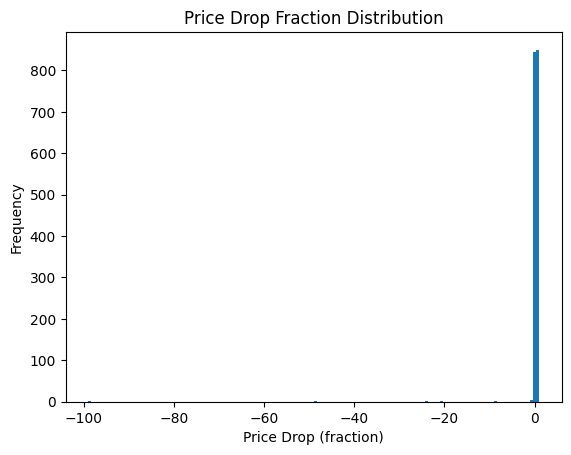

,url,listing_price,price_drop,discounted_shipping,style_tags,color,brand,new_with_tags,size,sub_category,category,bundle,listing_date,sold,days_since_listing,sellable,department,categories,style_tags_list
3209,https://poshmark.com/listing/Coach-Black-and-G...,100.0,-99.0,$8.27,other,['Black'],Coach,False,['OS'],Shoulder Bags,"['Women', 'Bags']",True,2025-05-09,True,47.0,1,Women,Bags,[]
3557,https://poshmark.com/listing/Arita-fatbaby-her...,50.0,-49.0,$8.27,other,"['Brown', 'Blue']",Ariat,False,['8'],Ankle Boots & Booties,"['Women', 'Shoes']",True,2025-04-11,True,75.0,1,Women,Shoes,[]
3609,https://poshmark.com/listing/Teva-Black-Leathe...,22.0,-21.0,$8.27,other,['Black'],other,False,['10'],Sandals,"['Women', 'Shoes']",True,2025-04-26,True,60.0,1,Women,Shoes,[]
3894,https://poshmark.com/listing/USPBL-Navy-Bucket...,10.0,-9.0,$8.27,other,"['Blue', 'Red']",Source Unknown,False,['OS'],Hats,"['Men', 'Accessories']",False,2025-01-18,False,158.0,0,Men,Accessories,[]
4520,https://poshmark.com/listing/Donald-J-Pliner-n...,25.0,-24.0,$8.27,other,"['Brown', 'Blue']",Donald J. Pliner,False,['10.5'],Loafers & Slip-Ons,"['Men', 'Shoes']",False,2025-05-08,True,48.0,1,Men,Shoes,"[preppy, business casual, office]"


In [581]:
plt.figure()
plt.hist(df['price_drop'].dropna(), bins=150)
plt.title("Price Drop Fraction Distribution")
plt.xlabel("Price Drop (fraction)")
plt.ylabel("Frequency")
plt.show()

extreme_pd = df['price_drop'] < -2
extreme_df = df[extreme_pd]
extreme_df.head()

To prevent such values from destabilizing our model, I chose to cap these values at the 99th percentile which preserves the ordering of these values while reducing their magnitude. Additionally, I took the log transform of the listing price to minimize the right skew from a handful of very expensive items.

In [582]:
upper = df['price_drop'].quantile(0.99)
df['price_drop_clipped'] = df['price_drop'].clip(upper=upper)

print(upper)

df['log_price'] = np.log1p(df['listing_price'])

0.977947947947948


### 7. Clean and Encode Categorical Data 

Next I cleaned the categorical data before one-hot encoding.

In [583]:
for c in ['discounted_shipping','brand','department','categories']:
    df[c] = (df[c].fillna('')
                 .astype(str)
                 .str.lower().str.strip())


In [584]:
# Fill any remaining blanks with 'unknown'
for c in ['brand','department','categories','color']:
    df[c] = df[c].replace('', 'unknown')


In [585]:
df = pd.get_dummies(
    df,
    columns=['discounted_shipping','brand','department','categories'],
    prefix=['ship','brand','dept','cat']
)


In [586]:
df = pd.concat([df, binarize_multilabel(df['style_tags_list'],'tag')], axis=1)

df['color_list'] = df['color'].apply(parse_list_literal)
df = pd.concat([df, binarize_multilabel(df['color_list'],'color')], axis=1)


### 8. Standardize & Drop Columns

Lastly, I standardized my numeric columns and dropped columns that would not be used in our analysis. 

In [587]:
scaler = StandardScaler()
num_feats = ['log_price','price_drop_clipped']
df[num_feats] = scaler.fit_transform(df[num_feats])


In [588]:
drop_cols = [
    'url','category','listing_date','listing_price','price_drop',
    'style_tags','color','style_tags_list','color_list', 'size', 'days_since_listing'
]
df.drop(columns=drop_cols, inplace=True, errors='ignore')


In [589]:
df.reset_index(drop=True, inplace=True)
df.head()

# df.to_csv('data/processed/poshmark_features.csv', index=False)


,new_with_tags,sub_category,bundle,sold,sellable,price_drop_clipped,log_price,ship_$4.99,ship_$5.95,ship_$8.27,ship_free,brand_7 for all mankind,brand_a new day,brand_abercrombie & fitch,brand_adidas,brand_adrianna papell,brand_aerie,brand_agolde,brand_aimee kestenberg,brand_alexandra bartlett,brand_alfani,brand_alo yoga,brand_altar'd state,brand_ambiance,brand_american eagle outfitters,brand_american living,brand_andrew marc,brand_ann taylor,brand_anne klein,brand_anthropologie,brand_antonio melani,brand_apple,brand_ariat,brand_aritzia,brand_arizona jean company,brand_armani collezioni,brand_artisan,brand_astr,brand_athleta,brand_ba&sh,brand_balenciaga,brand_banamic,brand_banana republic,brand_bar iii,brand_bcbgmaxazria,brand_beachlunchlounge,brand_bebe,brand_becca,brand_birkenstock,brand_blowfish,brand_blu pepper,brand_blue ice,brand_bottega veneta,brand_brighton,brand_brooks,brand_brooks brothers,brand_burberry,brand_cabi,brand_cable & gauge,brand_calvin klein,brand_carhartt,brand_carter's,brand_caslon,brand_cato,brand_cello,brand_champion,brand_chaus,brand_chico's,brand_christian siriano,brand_christopher & banks,brand_clarks,brand_cleobella,brand_club monaco,brand_coach,brand_coco bianco,brand_cole haan,brand_columbia,brand_converse,brand_cotton emporium,brand_crazy 8,brand_crown & ivy,brand_cult gaia,brand_cupshe,brand_dansko,brand_democracy,brand_dior,brand_disney,brand_divided,brand_dkny,brand_donald j. pliner,brand_dooney & bourke,brand_eddie bauer,brand_eileen fisher,brand_elite jeans,brand_eliza j,brand_ellen tracy,brand_entro,brand_evereve,brand_everlane,brand_express,brand_fabletics,brand_faherty,brand_fashion nova,brand_fila,brand_fiona & purple,brand_flying monkey,brand_footjoy,brand_for love and lemons,brand_forever 21,brand_fossil,brand_fp movement by free people,brand_free people,brand_frye,brand_fused hawaii,brand_gap,brand_george,brand_gian marco venturi,brand_gianni bini,brand_gildan,brand_greg norman collection,brand_gucci,brand_guess,brand_gymshark,brand_h&m,brand_handmade,brand_hanna andersson,brand_harley-davidson,brand_hollister,brand_hot topic,brand_hudson jeans,brand_inc international concepts,brand_j. crew,brand_j. crew factory,brand_j. jill,brand_jealous tomato,brand_jessica london,brand_joe's jeans,brand_juicy couture,brand_justice,brand_kate spade,brand_keds,brand_keen,brand_kendra scott,brand_kenneth cole,brand_l.l. bean,brand_lands' end,brand_lane bryant,brand_lauren ralph lauren,brand_lee,brand_levi's,brand_life stride,brand_liliana,brand_lilly pulitzer,brand_liverpool,brand_loft,brand_louis vuitton,brand_love j,brand_lpa,brand_lucky brand,brand_lululemon athletica,brand_madewell,brand_maeve,brand_magnetic me,brand_marine layer,brand_marvel,brand_maurices,brand_mcm,brand_mercedes amg petronas,brand_merona,brand_merrell,brand_michael kors,brand_michael tyler,brand_moda international,brand_mountain hardwear,brand_nanette lepore,brand_nation ltd,brand_neiman marcus,brand_new balance,brand_new era,brand_new york & company,brand_nicole miller,brand_nike,brand_nine west,brand_nirvana,brand_no boundaries,brand_nouvelle collection,brand_oakley,brand_old navy,brand_one teaspoon,brand_one33 social,brand_oshkosh b'gosh,brand_other,brand_outdoor voices,brand_patagonia,brand_patricia nash,brand_pendleton,brand_perry ellis,brand_pink victoria's secret,brand_pistola,brand_polo ralph lauren,brand_prada,brand_prana,brand_premier designs,brand_puma,brand_quiksilver,brand_quince,brand_rachel rachel roy,brand_rachel zoe,brand_ralph lauren,brand_reebok,brand_reformation,brand_rhythm.,brand_robert graham,brand_rockport,brand_rothy's,brand_rouje,brand_search for sanity,brand_sezane,brand_shade & shore,brand_shein,brand_simon miller,brand_simply vera vera wang,brand_skechers,brand_skims,brand_so,brand_soft surroundings,brand_sonoma,brand_source unknown,brand_spanx,brand_spense,brand_sporty & rich,brand_st. john sport by marie gray,brand_st. john's bay,brand_steve madden,brand_stuart weitzman,brand_studio blue,brand_